Объявим импорты и инициализируем необходимые функции

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings("ignore")

import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import os
from random import shuffle
from glob import glob


IMG_SIZE = (224, 224)  # Size of images

# Load image pixels from path with custom size
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return img #vgg16.preprocess_input(img)

# Training generator for inputs images
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# Testing generator for inputs images
def predict_generator(files):
    for path in tqdm(files):
        yield np.array([load_image(path)])

Загрузим изображения для тестовой и тренировочной выборки.
Для тренировочной выборки создадим объект Dataset из функции-генератора.

In [2]:
train_imgs = glob('data/train/*.jpg')
test_imgs = glob('data/test/*.jpg')

shuffle(train_imgs)
batch_size = 32
train_generator = partial(fit_generator, files=train_imgs, batch_size=batch_size)

train_dataset = tf.data.Dataset.from_generator(
                    train_generator,
                    output_signature=(
                             tf.TensorSpec(shape=(batch_size, 224,224,3), dtype=tf.uint8),
                             tf.TensorSpec(shape=(batch_size,), dtype=tf.float64)
                             )
                    )

val_samples = 5  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_imgs[:val_samples], val_samples))

Создадим этап обогащения данных с помощью слоев keras, для лучшего обучения модели, в условиях малого количества тренировочных данных.

In [3]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"), # Переворачивает по горизонтали 50% случайно выбранных изображений
     layers.RandomRotation(0.1), # Поворачивает входные изображения на случайный угол в диапазоне [-10%, +10%]
     layers.RandomZoom(0.2) # Случайныи образом изменяет масштаб изображения от -20% до +20%
     ]
)

Протестируем слой подав на него изображение и отрисуем результат

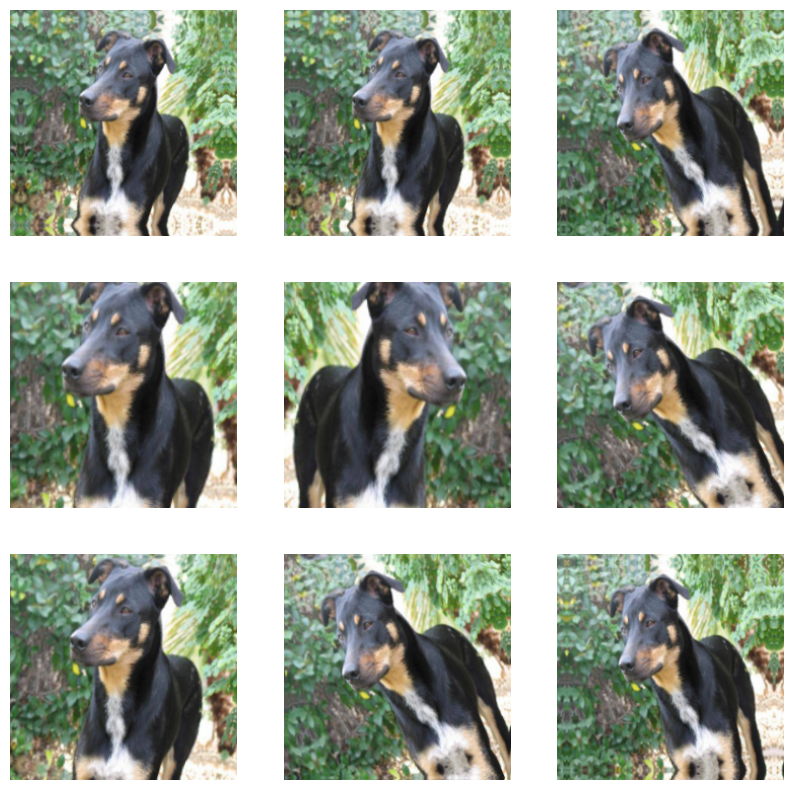

In [4]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        aug_imgs = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_imgs[0].numpy().astype("uint8"))
        plt.axis("off")

Составим модель нейронной сети

In [5]:
#conv_base = keras.applications.vgg16.VGG16(
#    weights="imagenet",
#    include_top=False)
#conv_base.trainable = False
#conv_base.summary()
       
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
#x = keras.applications.vgg16.preprocess_input(x)
#x = conv_base(x)
#x = layers.Flatten()(x)
#x = layers.Dense(256)(x)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 222, 222, 32)      0         
                                                             

Добавим сохранение весов и обучим нейронную сеть

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16.keras",
        save_best_only=True,
        monitor="val_loss"
        )]


# запускаем процесс обучения
history = model.fit(train_dataset,
              steps_per_epoch=25,  # число вызовов генератора за эпоху
              epochs=100,  # число эпох обучения
              validation_data=validation_data,
              callbacks=callbacks)


Сделаем предсказания на тестовой выборке и сохраним результаты, отправим на Kaggle.

In [7]:
test_pred = model.predict(predict_generator(test_imgs))
    
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_imgs, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Получил LogLoss: 0.27879